# HTTP3 vs HTTP2 Test Results Visualization
Source: HAR files located under `data/`.

Usage:
```
show_results('data/folder_with_har_files')
```

DE:
HTTP 3 median = 0.37398650002432987
HTTP 2 median = 0.35403749998658895
HTTP 3 mean = 0.4182945600012317
HTTP 2 mean = 0.3752814199938439
HTTP 3 fastest 90 percentile median = 0.3716689998982474
HTTP 2 fastest 90 percentile median = 0.3487239999230951
HTTP 3 min = 0.3287610000697896
HTTP 2 min = 0.3029549999628216


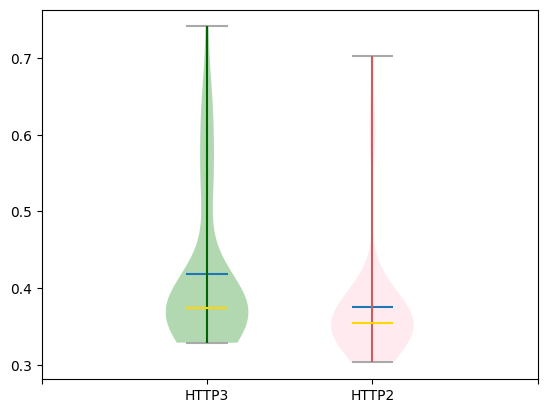

FI:
HTTP 3 median = 0.43285199999809265
HTTP 2 median = 0.4204940000199713
HTTP 3 mean = 0.4335230204071232
HTTP 2 mean = 0.4470946326512102
HTTP 3 fastest 90 percentile median = 0.43104299998958595
HTTP 2 fastest 90 percentile median = 0.41925950000586454
HTTP 3 min = 0.380072999978438
HTTP 2 min = 0.3848009999783244


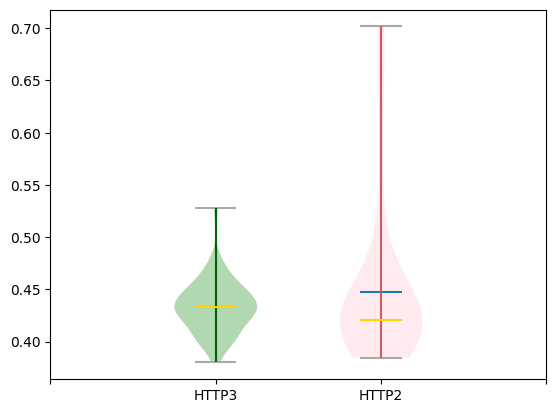

US:
HTTP 3 median = 0.8937149999837857
HTTP 2 median = 1.0848879999975907
HTTP 3 mean = 0.9145342200004961
HTTP 2 mean = 1.1399072499983351
HTTP 3 fastest 90 percentile median = 0.8922230000025593
HTTP 2 fastest 90 percentile median = 1.0194100000080653
HTTP 3 min = 0.8397169999952894
HTTP 2 min = 0.9201199999952223


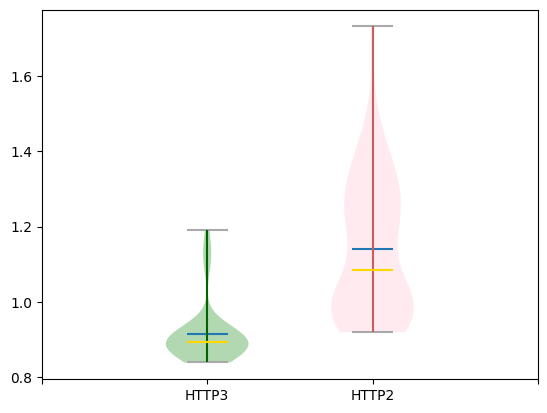

In [22]:
import numpy as np
import json
import glob
import matplotlib.pyplot as plt

def json_from_file(path):
    f = open(path, "r")
    json_data = json.loads(f.read())
    return json_data

def summarize_response_time(json_data, include_script=True):
    """
    :param json_data: raw json data from a har file
    :param include_script: If set to False, it stops counting time
           on the first request initiated by a script, not to include in the total time
           async requests from third party scripts.
    :return: summed response time
    """
    request_time = 0.0
    start_time = 0.0
    i = 0
    for entry in json_data['log']['entries']:
        if float(entry['_requestTime']) > 0:
            if not include_script and str(entry['_initiator_type']) == 'script':
                break
            if start_time == 0: start_time = float(entry['_requestTime'])
            request_time = float(entry['_requestTime'])
        i += 1
    return request_time - start_time


def get_results(results_list, index, include_script=True):
    x = []
    y = []
    for i, entry in enumerate(results_list):
        x.append(index)
        y.append(summarize_response_time(entry, include_script))

    return x, y


def get_lowest_values(results, percentile):
    sorted_results = np.sort(results)
    index = int(len(sorted_results) * percentile / 100)
    lowest_values = sorted_results[:index]
    return lowest_values

def show_results(path, include_script=True):
    http3_list = []
    http2_list = []

    for file in glob.glob(path + '/http3/*.har'):
        data = json_from_file(file)
        http3_list.append(data)

    for file in glob.glob(path + '/http2/*.har'):
        data = json_from_file(file)
        http2_list.append(data)

    http3_x, http3_y = get_results(http3_list, 1, include_script)
    http2_x, http2_y = get_results(http2_list, 2, include_script)

    print('HTTP 3 median = ' + str(np.median(http3_y)))
    print('HTTP 2 median = ' + str(np.median(http2_y)))
    print('HTTP 3 mean = ' + str(np.mean(http3_y)))
    print('HTTP 2 mean = ' + str(np.mean(http2_y)))
    print('HTTP 3 fastest 90 percentile median = ' + str(np.median(get_lowest_values(http3_y, 90))))
    print('HTTP 2 fastest 90 percentile median = ' + str(np.median(get_lowest_values(http2_y, 90))))
    print('HTTP 3 min = ' + str(np.min(http3_y)))
    print('HTTP 2 min = ' + str(np.min(http2_y)))

    plot = plt.violinplot([http3_y, http2_y], showmedians=True, showmeans=True)
    plt.xticks(range(0, 4), ['', 'HTTP3', 'HTTP2', ''])

    bgcolors = ['green', 'pink']
    mediancolors = ['gold', 'gold']
    barcolors = ['darkgreen', 'indianred']
    extremescolors = ['darkgray', 'darkgray']

    for patch, color in zip(plot['bodies'], bgcolors):
        patch.set_facecolor(color)
        patch.set_edgecolor(None)

    plot['cmedians'].set_colors(mediancolors)
    plot['cmins'].set_colors(extremescolors)
    plot['cmaxes'].set_colors(extremescolors)
    plot['cbars'].set_colors(barcolors)

    plt.show()

print("DE:")
show_results('data/de', False)
print("FI:")
show_results('data/fi', False)
print("US:")
show_results('data/us', False)
